Энтропия и решающие деревья

In [217]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (9, 6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [218]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

In [219]:
#!pip install mlxtend
from mlxtend.plotting import plot_decision_regions

**Энтропия** 

$$\large S = - \sum_{i=1}^N p_i log_2 p_i$$
где $p_i$ - вероятность найти систему в i-ом состоянии.



Информационный выигрыш (Information Gain, IG) для разделения на основе признака Q выглядит следующим образом:

$$\large IG(Q)=S_0 - \sum_{i=1}^q\frac{N_i}{N} S_i$$

где $q$ - число групп после деления, $N_i$ - количество объектов в выборке, в которой признак $Q$ равен i-ому значению.

**Информационный выигрыш = сколько энтропии мы удалили**

Реализую функции для вычисления энтропии и информационного выигрыша

Есть 9 синий и 11 жёлтых мячей. Пусть мяч будет иметь метку **1**, если он синий, **0** в противном случае.

In [220]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<img src = 'https://habrastorage.org/webt/mu/vl/mt/muvlmtd2njeqf18trbldenpqvnm.png'>

Затем разделим мячи на две группы по некоторому признаку:

<img src='https://habrastorage.org/webt/bd/aq/5w/bdaq5wi3c4feezaexponvin8wmo.png'>

In [221]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 жёлтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 жёлтых
balls_left, balls_right

([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0])

Напишем функцию, вычисляющую энтропию по Шеннону,применим её для для следующих наборов данных.

In [222]:
def entropy(list_):
    classes = []
    for i in list_:
        if i not in classes:
            classes.append(i)
    for ind in range(len(classes)):
        cl = classes[ind]
        classes[ind] = list_.count(cl)/len(list_)
    probs = np.array(classes)
    return -sum(probs * np.log2(probs))


'''с функционалом numpy'''

def entropy1(list_):
    unique, counts = np.unique(list_, return_counts=True)
    probs = counts / len(list_)
    return -np.sum(probs * np.log2(probs))

In [223]:
li= np.array([4,6,7,8,9])
li2 = np.array([3,5,6,7,8])
print(li*li2)


[12 30 42 56 72]


Проверка:

In [224]:
print(entropy(balls)) # 9 синих и 11 жёлтых
print(entropy(balls_left)) # 8 синих и 5 жёлтых
print(entropy(balls_right)) # 1 синий и 6 жёлтых

0.9927744539878083
0.9612366047228759
0.5916727785823275


In [225]:
print(entropy1(balls)) # 9 синих и 11 жёлтых
print(entropy1(balls_left)) # 8 синих и 5 жёлтых
print(entropy1(balls_right)) # 1 синий и 6 жёлтых

0.9927744539878083
0.9612366047228759
0.5916727785823275


In [226]:
'''энтропия бросания монетки '''
monetka = [0,1]
print(entropy(monetka))

1.0


In [227]:
''' энтропия игральной кости '''
kost = list(range(6))
print(entropy(kost))

2.584962500721156


In [228]:
# вычисление информационного выигрыша
'''информационный выигрыш при делении исходных данных на balls_left and balls_right '''

def information_gain(full_data, left, right):
    ''' full_data - исходные данные, left и right - две части исходных данных'''
    N = len(full_data)
    ig = entropy(full_data) - (entropy(left)*(len(left)/N) + entropy(right)*(len(right)/N))
    return ig

Проверка:

In [229]:
print(round(information_gain(balls, balls_left, balls_right), 3))

0.161


Задача классификации
Данные -  The "Adult" Dataset.

[Dataset](https://www.kaggle.com/datasets/sagnikpatra/uci-adult-census-data-dataset) 

Входные признаки:

- **Age** – непрерывный признак
- **Workclass** –  непрерывный признак
- **fnlwgt** – конечный вес объекта, непрерывный признак
- **Education** –  категориальный признак
- **Education_Num** – количество лет образования, непрерывный признак
- **Martial_Status** –  категориальный признак
- **Occupation** –  категориальный признак
- **Relationship** – категориальный признак
- **Race** – категориальный признак
- **Sex** – категориальный признак
- **Capital_Gain** – непрерывный признак
- **Capital_Loss** – непрерывный признак
- **Hours_per_week** – непрерывный признак
- **Country** – категориальный признак

**Target** – уровень дохода, категориальный (бинарный) признак.

In [230]:
# Загрузка файла

!wget https://raw.githubusercontent.com/hse-ds/ml-hse-nes/refs/heads/main/2024/homeworks/homework_4/adult_train.csv

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [231]:
# Загрузка файла

!wget https://raw.githubusercontent.com/hse-ds/ml-hse-nes/refs/heads/main/2024/homeworks/homework_4/adult_test.csv

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [232]:
data_train = pd.read_csv('adult_train.csv')

In [233]:
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [234]:
data_test = pd.read_csv('adult_test.csv')

In [235]:
data_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [236]:
# удаляем строчки с неверными метками в тестовых данных
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# кодируем целевую переменную как целое число
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

In [237]:
data_train.isna().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64

In [238]:
data_test.isna().sum()

Age                 0
Workclass         963
fnlwgt              0
Education           0
Education_Num       0
Martial_Status      0
Occupation        966
Relationship        0
Race                0
Sex                 0
Capital_Gain        0
Capital_Loss        0
Hours_per_week      0
Country           274
Target              0
dtype: int64

Первичный анализ датасета.

In [239]:
data_test.describe()

,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
count,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [240]:
data_train['Target'].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

In [241]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.tight_layout()

In [242]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [243]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

В тестовых данных признак Age рассматривается, как  **object**, исправим это

In [244]:
data_test['Age'] = data_test['Age'].astype(int)

In [1]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

NameError: name 'data_test' is not defined

In [246]:
# выбираем категориальные и непрерывные признаки из данных

categorical_columns = [c for c in data_train.columns
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [247]:
# можно заметить пропущенные значения
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [248]:
# заполняем пропущенные значения
for c in categorical_columns:
    data_train[c] = data_train[c].fillna(data_train[c].mode()[0])
    data_test[c] = data_test[c].fillna(data_test[c].mode()[0])

for c in numerical_columns:
    data_train[c] = data_train[c].fillna(data_train[c].median())
    data_test[c] = data_test[c].fillna(data_test[c].median())

In [249]:
# пропусков нет
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


Закодируем некоторые категориальные признаки: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**

In [250]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [251]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [252]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

создаем новый нулевой признак

In [253]:
data_test['Country_ Holand-Netherlands'] = 0

In [254]:
set(data_train.columns) - set(data_test.columns)

set()

In [255]:
data_train.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [256]:
data_test.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [257]:
data_train = pd.concat([data_train.drop(['Country_ Holand-Netherlands'], axis=1), data_train['Country_ Holand-Netherlands']], axis=1)

In [258]:
data_train.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [259]:
data_test.head(1)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [260]:
data_train.shape, data_test.shape

((32561, 106), (16281, 106))

In [261]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']



Обучим `DecisionTreeClassifier` с глубиной 3. потом посчитаем метрики: `Accuracy`, `Precision`, `Recall` и `F1`

In [2]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_clf.fit(X_train, y_train)

NameError: name 'DecisionTreeClassifier' is not defined

In [263]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 17,
 'splitter': 'best'}

In [264]:
tree_predictions = tree_clf.predict(X_test)
tree_predictions_proba = tree_clf.predict_proba(X_test)[:,1]

In [280]:
tree_predictions[:5]

array([0, 0, 0, 1, 0])

In [266]:
tree_predictions_proba[:5]

array([0.02466821, 0.29672312, 0.29672312, 0.97916667, 0.02466821])

 считаем `Accuracy`:

In [267]:
tree_accuracy = accuracy_score(tree_predictions, y_test) 
tree_precision = precision_score(tree_predictions, y_test) 
tree_recall = recall_score(tree_predictions, y_test) 
tree_f1score = f1_score(tree_predictions, y_test) 
print(f'Accuracy: {tree_accuracy}', f'Precision: {tree_precision}', f'Recall: {tree_recall}', f'F1-score: {tree_f1score}' , sep = '\n')

Accuracy: 0.8447884036607088
Precision: 0.5070202808112324
Recall: 0.7555211158465711
F1-score: 0.6068149992220321


In [ ]:
'''Модель имеет высокую "чувствительность", но низкую "точность,
Recall = 0.756, следовательно, модель находит 75.6% всех положительных примеров,
Precision = 0.507, следовательно, 50.7% найденных действительно положительные.
Данные,скорее всего, не сбалансированы, отрицательный класс должен сильно преобладать(что видно,
если просто вывести y_train, y_test), потому что у нас 
высокий Accuracy и низкий Precision. Дерево может хорошо предсказать отрицательный класс(которого больше),
но плохо предсказывает положительный класс(более редкий)'''



* ROC-кривая, AUC ROC:

*  Precision-Recall-кривая, Average Precision:

In [3]:
fpr, tpr, _ = roc_curve(y_test, tree_predictions_proba)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr)
plt.show()

NameError: name 'roc_curve' is not defined

In [273]:
'''ROC-AUC'''
rocauc = auc(fpr, tpr)
print(f'ROC-AUC: {rocauc}')

ROC-AUC: 0.8624154495733508


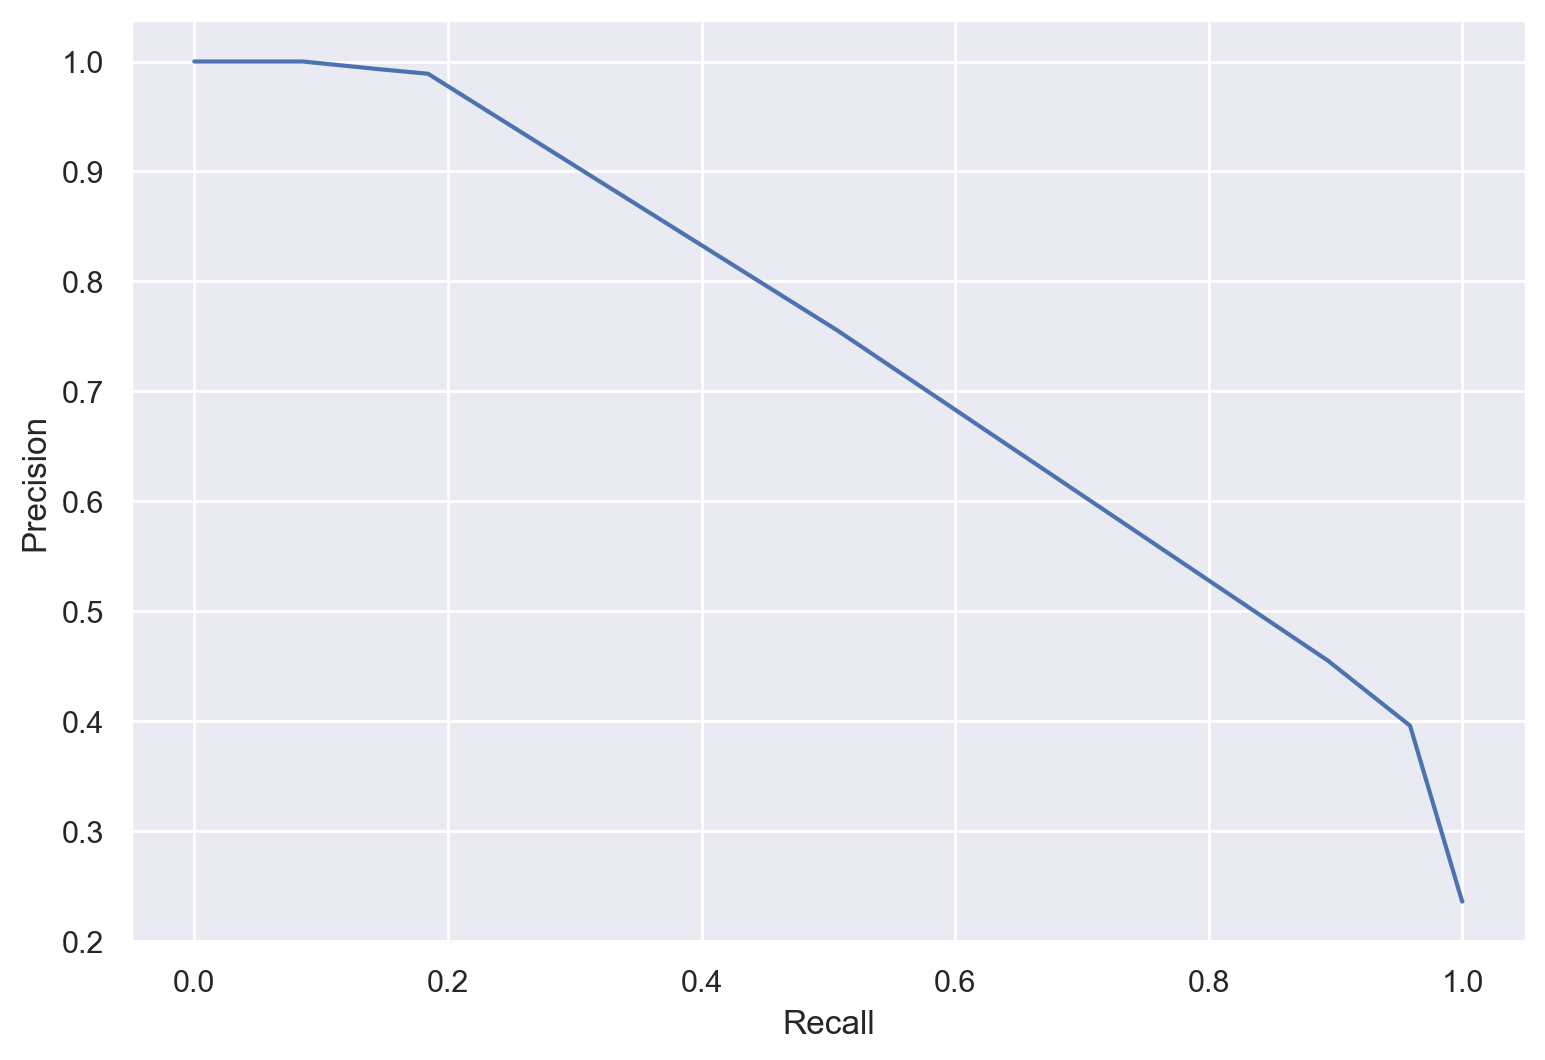

In [274]:
prec, rec, _ = precision_recall_curve(y_test, tree_predictions_proba)
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [275]:
'''Average Precision Score'''
aps = average_precision_score(y_test, tree_predictions_proba)
print(f'Average Precision Score: {aps}')


Average Precision Score: 0.638796314804034


In [ ]:
''' Как я уже сказала, данные не сбалансированы,много 0, мало 1.
ROC-AUC(0.862) высокий, AP(0.639) довольно низкий, следовательно, модель хорошо разделяет классы,
но ей сложно точно идентифицировать положительный класс''' 


обучим модель на дефолтных датасетах из sklearn, сравним `Accuracy` для каждого случая.далее сделаем визуализацию

In [96]:
# датасеты

datasets = [
    make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=17),
    make_moons(n_samples=1000, noise=0.1, random_state=17),
    make_classification(n_samples=1000, n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=17,
                        n_redundant=0)
]

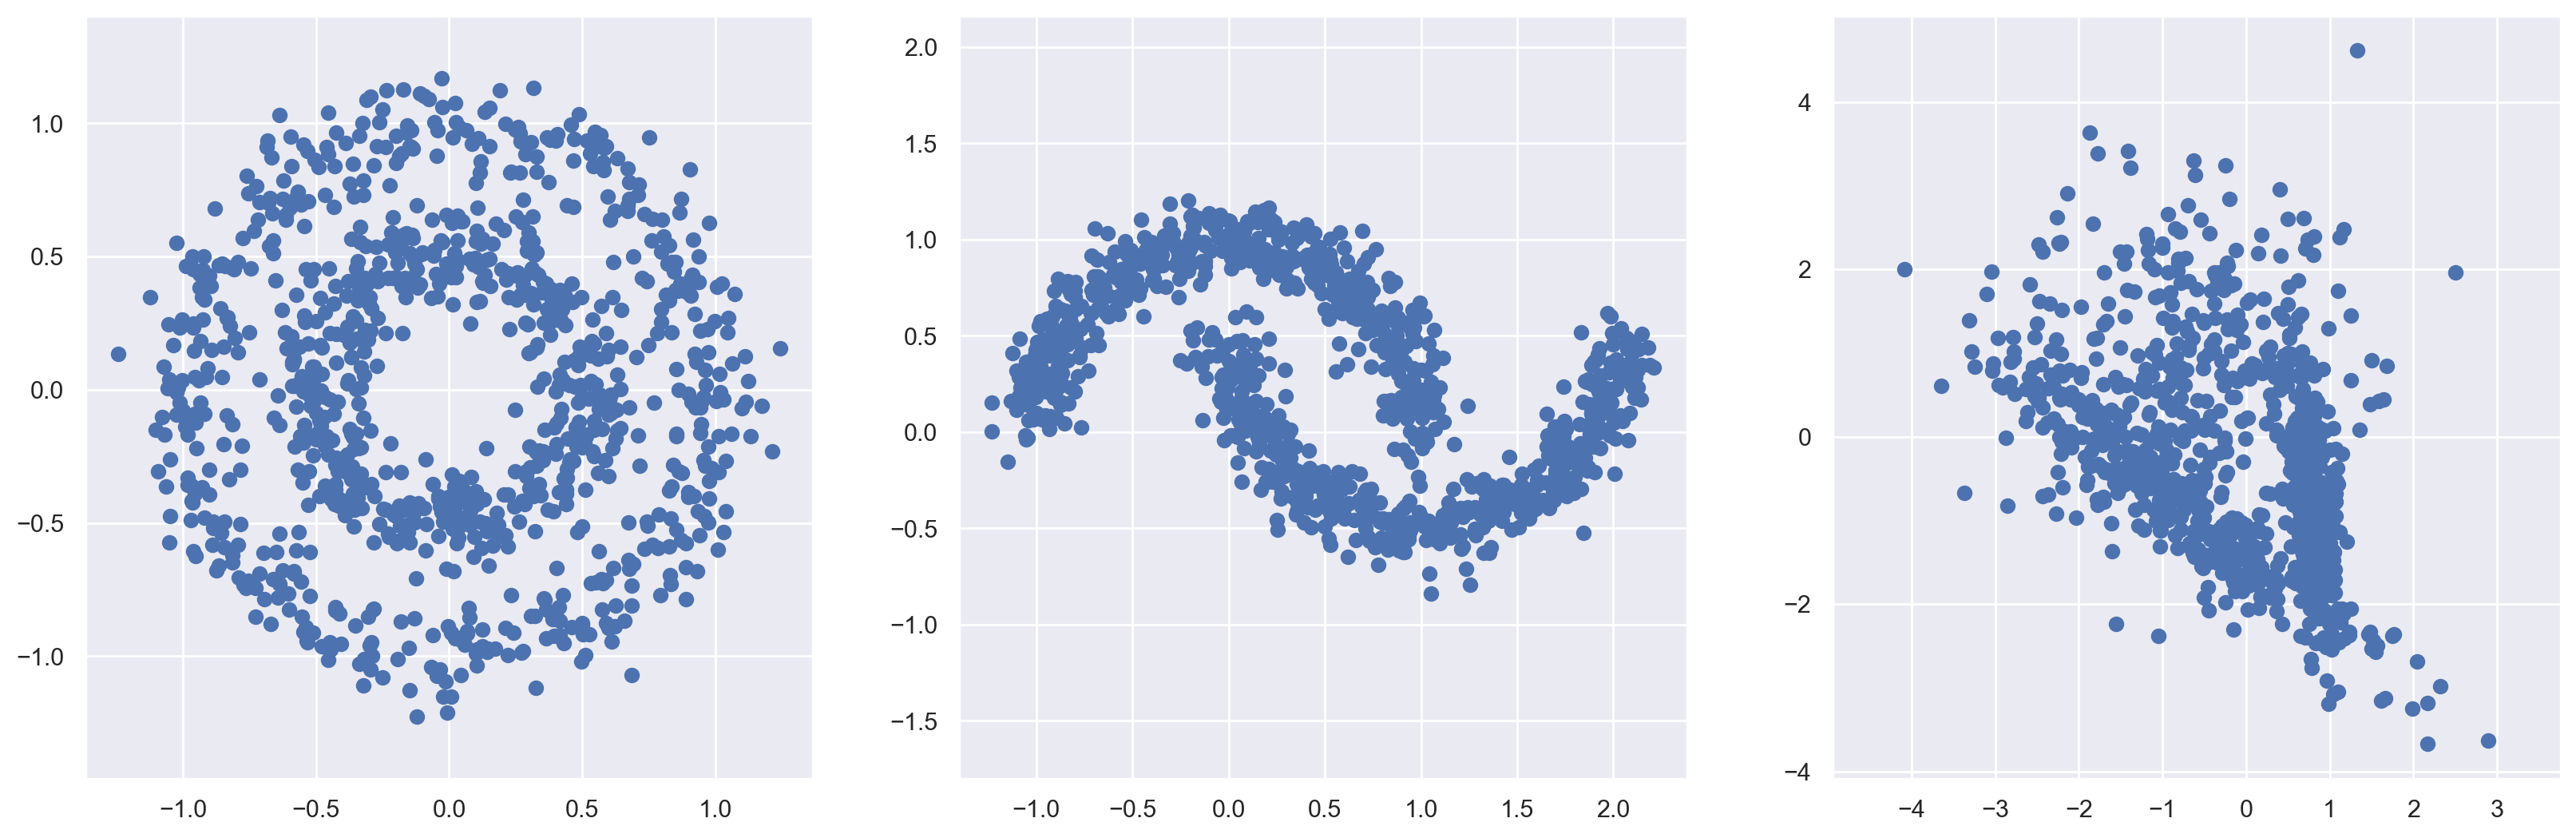

In [126]:
plt.figure(figsize=(20, 6.2))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(datasets[i][0][:, 0], datasets[i][0][:, 1])
    plt.axis('equal')
plt.show()



In [153]:
trees = [DecisionTreeClassifier(random_state=17) for i in range(3)]
acc_list =[]
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], random_state=17)
    trees[i].fit(X_train, y_train)
    y_pred = trees[i].predict(X_test)
    tree_acc = accuracy_score(y_pred, y_test)
    acc_list.append(tree_acc)
print(f'Accuracy_1: {acc_list[0]}', f'Accuracy_2: {acc_list[1]}', f'Accuracy_3: {acc_list[2]}', sep='\n')
    
    
    
    

Accuracy_1: 0.992
Accuracy_2: 0.992
Accuracy_3: 0.772


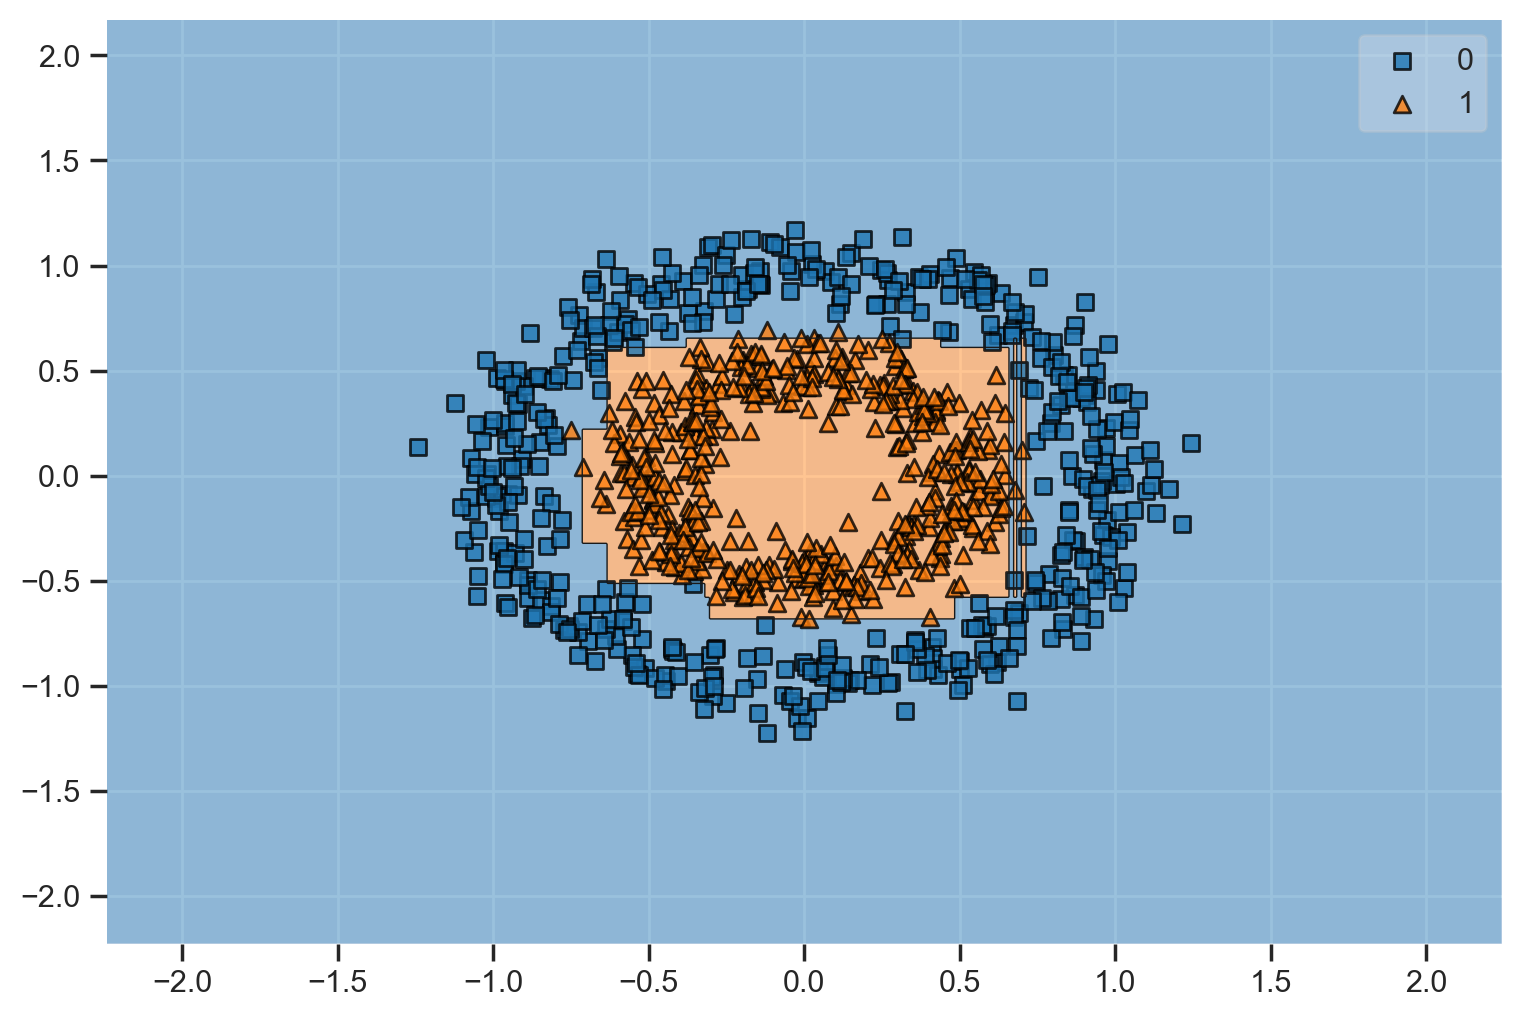

In [149]:
'''первый датасет'''
plot_decision_regions(datasets[0][0], datasets[0][1], clf=trees[0])
plt.show()

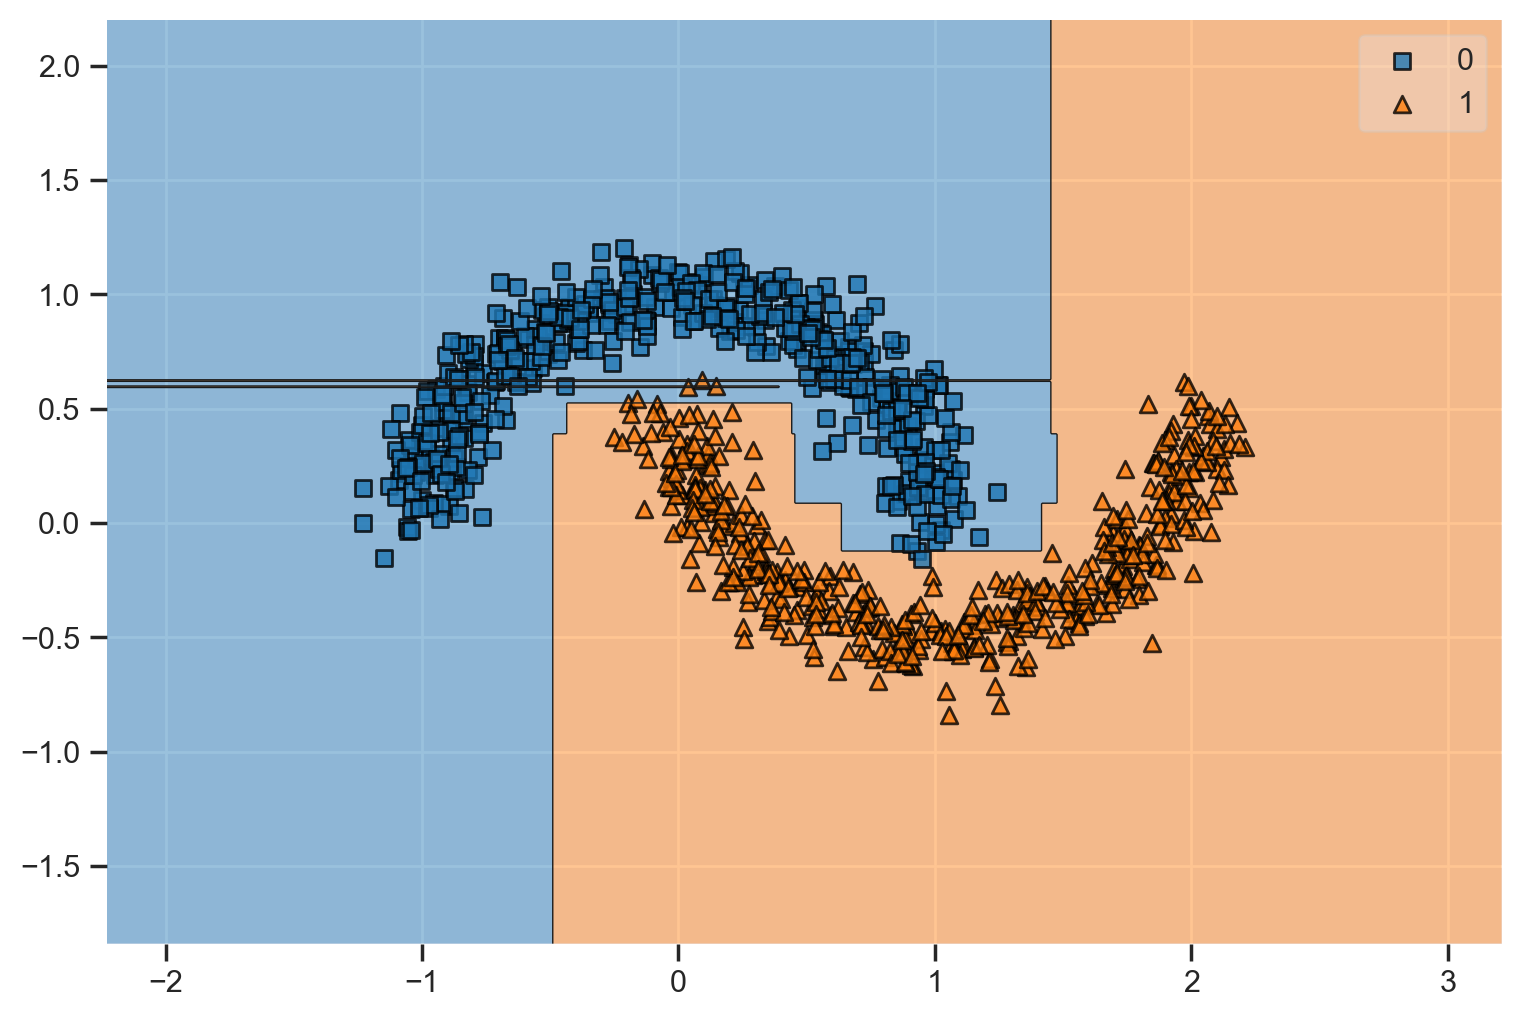

In [150]:
'''второй датасет'''
plot_decision_regions(datasets[1][0], datasets[1][1], clf=trees[1])
plt.show()

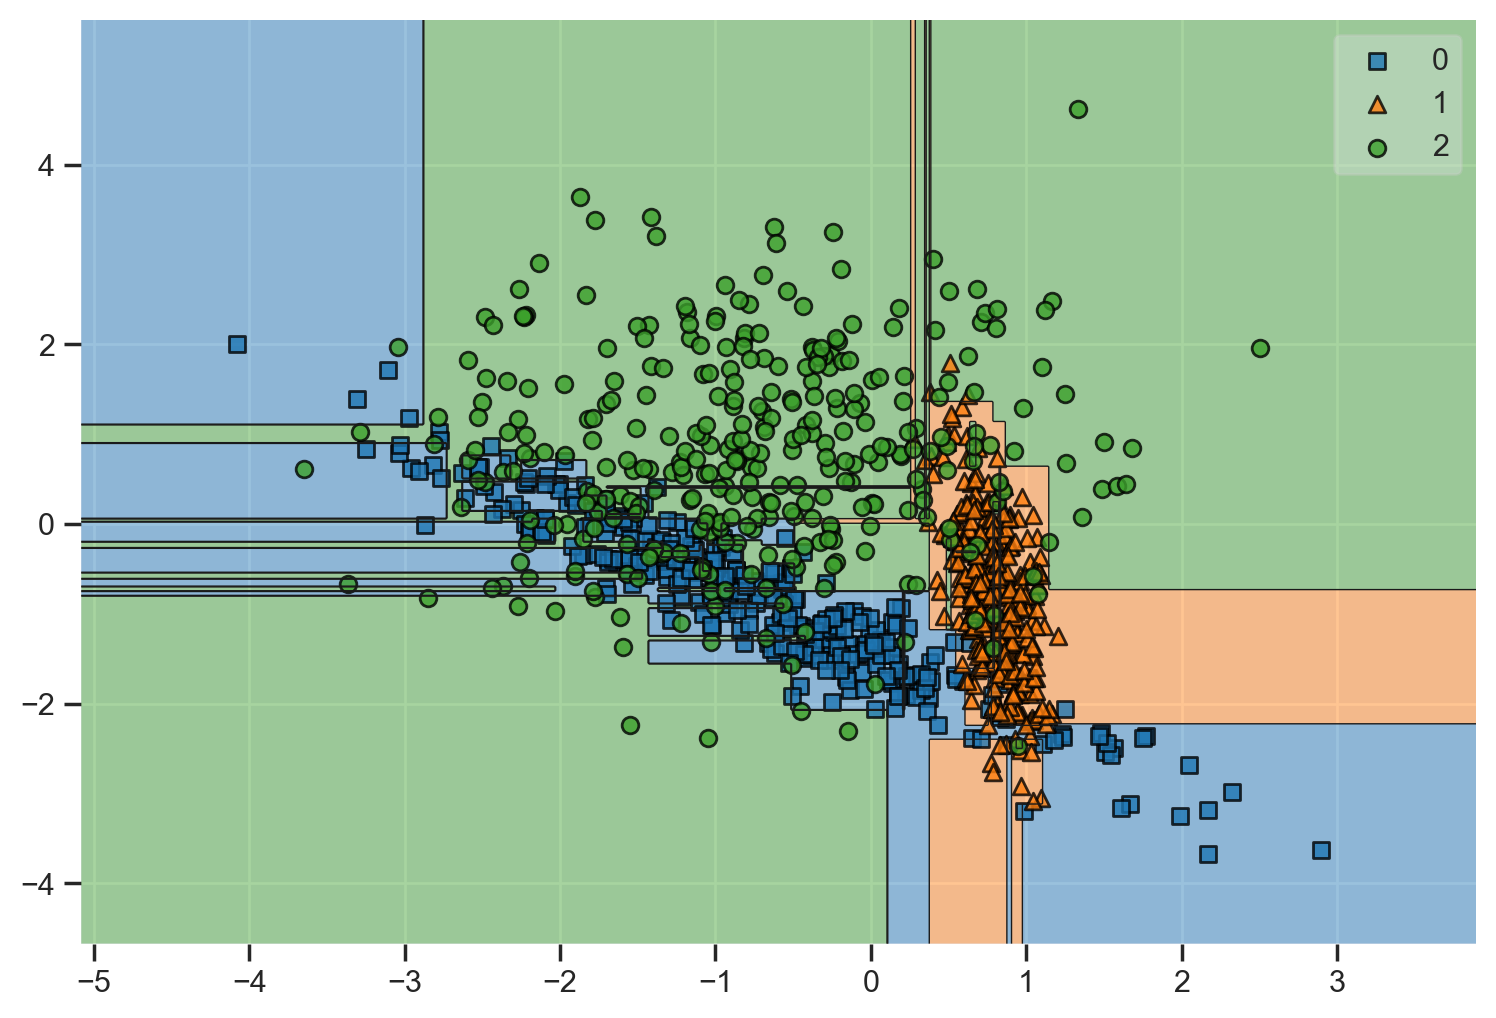

In [151]:
'''третий датасет'''
plot_decision_regions(datasets[2][0], datasets[2][1], clf=trees[2])
plt.show()

In [ ]:
'''Для первых двух датасетов accuracy очень высокая(0,99), что может говорить о переобучении,
для третьего датасета accuracy средняя. На графиках видны 
визуальные признаки переобучения - для make_circles граница с множеством углов,а не плавная круглая 
линия и оражевые "выбросы" справа.Для moons - также граница с множеством углов, 
для make_classification - куча лишних выбросов, мелких изгибов, углов, но его accuracy ниже, 
вероятно, потому что класса 3 и они сильно перемешаны, особенно синий и зеленый.
Если дерево переобучается, можно добавлять критерии останова - макисмальную глубину дерева,
минимального уменьшение значения критерия информативности, 
минимальное количество объектов в листьях, ограничение максимального количества листьев, 
можно также использовать прунинг(стрижку дерева) или сделать ансамбль деревьев.'''